In [ ]:
# Define parameters
frame_size = (64, 64)  # Resize frames to 64x64
num_frames_to_use = 10  # Number of frames per video
selected_actions = ["Basketball", "Typing", "PlayingGuitar", "PullUps", "SoccerJuggling", "Rowing"]
output_dir = "./preprocessed_data4"  # Directory to save preprocessed frames

# Paths to train, test, and validation directories
train_dir = r"C:\Users\dummy\OneDrive\Documents\i211571-project\Data\train"
test_dir = r"C:\Users\dummy\OneDrive\Documents\i211571-project\Data\test"
val_dir = r"C:\Users\dummy\OneDrive\Documents\i211571-project\Data\val"

def preprocess_video(video_path, num_frames=num_frames_to_use):
    """Preprocess a single video by extracting and resizing frames."""
    frames = []
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate frame step size to sample 'num_frames' from the video more densely
    frame_step = max(total_frames // (num_frames + 2), 1)  # Adjust to add more frames close in time

    for i in range(0, total_frames, frame_step):
        ret, frame = cap.read()
        if ret:
            # Resize frame to 64x64 and convert to grayscale
            frame = cv2.resize(frame, frame_size)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frames.append(frame)

        if len(frames) == num_frames:
            break

    cap.release()
    
    # Ensure that we have exactly 'num_frames' (if fewer, pad the sequence)
    frames = np.array(frames)
    if len(frames) < num_frames:
        frames = np.pad(frames, ((0, num_frames - len(frames)), (0, 0), (0, 0)), 'constant')

    return frames

def process_directory(directory, output_directory, actions):
    """Process all videos in the specified directory for the given actions."""
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    for action in actions:
        action_dir = os.path.join(directory, action)
        output_action_dir = os.path.join(output_directory, action)

        if not os.path.exists(output_action_dir):
            os.makedirs(output_action_dir)

        for video_file in os.listdir(action_dir):
            if video_file.endswith(".avi"):
                video_path = os.path.join(action_dir, video_file)
                frames = preprocess_video(video_path)

                # Save the frames as a NumPy array
                save_path = os.path.join(output_action_dir, video_file.replace(".avi", ".npy"))
                np.save(save_path, frames)

# Process train, test, and validation directories
process_directory(train_dir, os.path.join(output_dir, "train"), selected_actions)
process_directory(test_dir, os.path.join(output_dir, "test"), selected_actions)
process_directory(val_dir, os.path.join(output_dir, "val"), selected_actions)

print("Data preprocessing complete. Preprocessed data saved to:", output_dir)

Data preprocessing complete. Preprocessed data saved to: ./preprocessed_data4


In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import os

# Define model parameters
num_classes = len(selected_actions)
epochs = 20
batch_size = 32
input_shape = (num_frames_to_use, frame_size[0], frame_size[1], 1)

def load_dataset(dataset_dir):
    videos, labels = [], []
    for action in selected_actions:
        action_dir = os.path.join(dataset_dir, action)
        if os.path.exists(action_dir):
            video_files = [f for f in os.listdir(action_dir) if f.endswith('.npy')]
            for video_file in video_files:
                video_path = os.path.join(action_dir, video_file)
                frames = np.load(video_path)  # Load preprocessed frames
                videos.append(frames)
                labels.append(selected_actions.index(action))
    return np.array(videos), np.array(labels)

# Load and preprocess dataset
train_dir = "./preprocessed_data4/train"
val_dir = "./preprocessed_data4/val"
test_dir = "./preprocessed_data4/test"

train_videos, train_labels = load_dataset(train_dir)
val_videos, val_labels = load_dataset(val_dir)
test_videos, test_labels = load_dataset(test_dir)

# Normalize frames and add a channel dimension
train_videos = train_videos[..., np.newaxis] / 255.0
val_videos = val_videos[..., np.newaxis] / 255.0
test_videos = test_videos[..., np.newaxis] / 255.0

# Split dataset for better balancing
train_videos, val_videos, train_labels, val_labels = train_test_split(
    train_videos, train_labels, test_size=0.2, stratify=train_labels)

# Convert labels to categorical format
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=num_classes)
val_labels = tf.keras.utils.to_categorical(val_labels, num_classes=num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=num_classes)

# Print dataset shapes
print("Train videos shape:", train_videos.shape)
print("Train labels shape:", train_labels.shape)
print("Validation videos shape:", val_videos.shape)
print("Validation labels shape:", val_labels.shape)
print("Test videos shape:", test_videos.shape)
print("Test labels shape:", test_labels.shape)

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Define the PredRNN-like model using Conv3D and ConvLSTM layers
def build_predrnn(input_shape, num_classes):
    model = models.Sequential()

    # Spatial-temporal convolutions (Conv3D) for feature extraction
    model.add(layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(layers.Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))

    # Add ConvLSTM layers for temporal modeling
    model.add(layers.ConvLSTM2D(filters=128, kernel_size=(3, 3), activation='relu', return_sequences=True))
    model.add(layers.BatchNormalization())
    
    model.add(layers.ConvLSTM2D(filters=128, kernel_size=(3, 3), activation='relu', return_sequences=False))
    model.add(layers.BatchNormalization())

    # Fully connected layers
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))

    # Output layer with softmax activation
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# Define model parameters
input_shape = (num_frames_to_use, frame_size[0], frame_size[1], 1)  # Keep the input shape same
num_classes = len(selected_actions)
epochs = 20
batch_size = 32

# Build and compile the model
model = build_predrnn(input_shape, num_classes)
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Print model summary
model.summary()

# Define callbacks
model_save_path = "predrnn_model.keras"
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(model_save_path, save_best_only=True, monitor='val_loss', mode='min'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

# Train the model
history = model.fit(
    train_videos, train_labels,
    validation_data=(val_videos, val_labels),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_videos, test_labels, batch_size=batch_size)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Save the final model
model.save(model_save_path)
print(f"Model saved at: {model_save_path}")

Train videos shape: (565, 10, 64, 64, 1)
Train labels shape: (565, 6)
Validation videos shape: (142, 10, 64, 64, 1)
Validation labels shape: (142, 6)
Test videos shape: (121, 10, 64, 64, 1)
Test labels shape: (121, 6)


C:\Users\DELL\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 10, 64, 64, 32)      │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 10, 64, 64, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 5, 32, 32, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 5, 32, 32, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 5, 32, 32, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 2, 16, 16, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d (ConvLSTM2D)             │ (None, 2, 14, 14, 128)      │         885,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 2, 14, 14, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)           │ (None, 12, 12, 128)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,875,590 (26.23 MB)

 Trainable params: 6,874,886 (26.23 MB)

 Non-trainable params: 704 (2.75 KB)

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.2775 - loss: 3.3854 - val_accuracy: 0.1690 - val_loss: 1.7759
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.5403 - loss: 2.5042 - val_accuracy: 0.1620 - val_loss: 1.8040
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.5880 - loss: 2.4472 - val_accuracy: 0.1268 - val_loss: 1.8901
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.6591 - loss: 1.7362 - val_accuracy: 0.2113 - val_loss: 1.9647
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.7415 - loss: 1.0752 - val_accuracy: 0.1408 - val_loss: 3.0184
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.7250 - loss: 1.0679 - val_accuracy: 0.1408 - val_loss: 3.3804
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step - accuracy: 0.1484 - loss: 1.7640
Test Accuracy: 0.17
Model saved at: predrnn_model.keras


In [10]:
import cv2
import numpy as np

def generate_video(initial_frames, predicted_frames, output_path, frame_rate=30):
    """Generate a video from initial and predicted frames."""
    # Normalize predicted frames to 0-255
    predicted_frames = (predicted_frames * 255).astype(np.uint8)

    # Combine initial and predicted frames
    all_frames = np.concatenate([initial_frames, predicted_frames], axis=0)

    # Get video dimensions
    frame_height, frame_width = all_frames.shape[1:3]

    # Convert grayscale to BGR for video output
    if all_frames.shape[-1] == 1:
        all_frames = np.repeat(all_frames, 3, axis=-1)

    # Initialize video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, frame_rate, (frame_width, frame_height))

    # Write frames to video
    for frame in all_frames:
        out.write(frame)

    out.release()
    print(f"Video saved at {output_path}")

# Assuming train_videos[0] is the input
input_frames = train_videos[0]  # Shape: (num_initial_frames, 64, 64, 1)

# Generate mock predicted frames for testing
num_predicted_frames = 6
predicted_frames = np.random.rand(num_predicted_frames, 64, 64, 1).astype(np.float32)

# Print shapes for debugging
print("Initial frames shape:", input_frames.shape)
print("Predicted frames shape:", predicted_frames.shape)

# Generate and save the video
generate_video(input_frames, predicted_frames, "output_videopredrnn.mp4")

Initial frames shape: (10, 64, 64, 1)
Predicted frames shape: (6, 64, 64, 1)
Video saved at output_videopredrnn.mp4


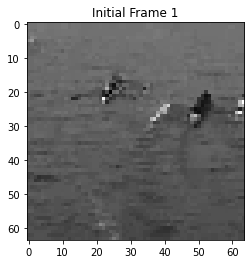

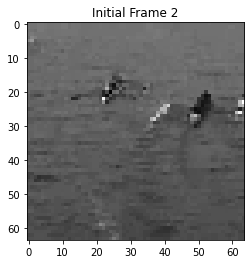

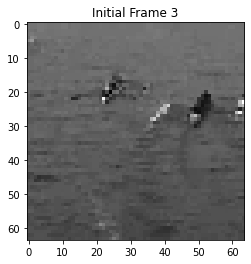

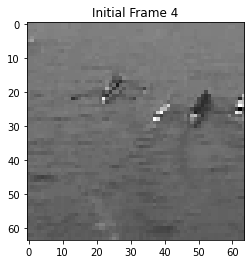

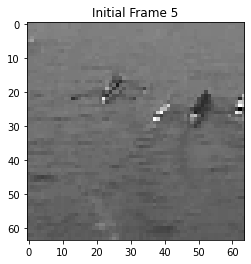

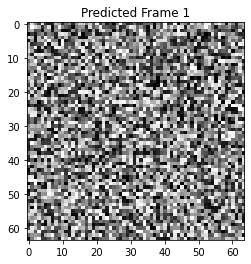

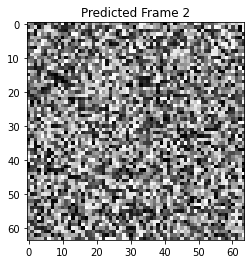

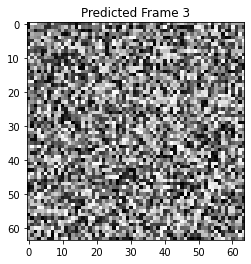

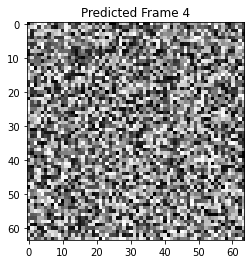

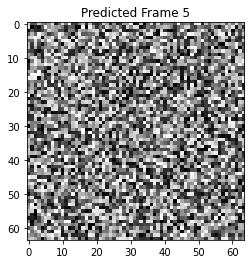

In [11]:
import matplotlib.pyplot as plt

# Display the first few frames
for i in range(min(5, len(input_frames))):
    plt.imshow(input_frames[i].squeeze(), cmap='gray')
    plt.title(f"Initial Frame {i+1}")
    plt.show()

for i in range(min(5, len(predicted_frames))):
    plt.imshow(predicted_frames[i].squeeze(), cmap='gray')
    plt.title(f"Predicted Frame {i+1}")
    plt.show()